In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
import math
import random
import functools

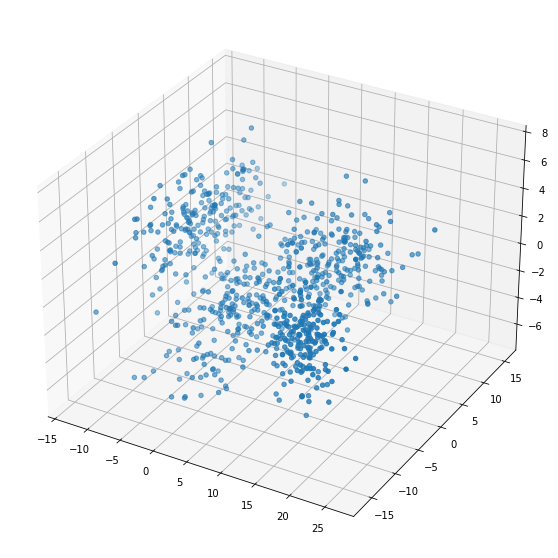

In [40]:
X = np.load("./data.npy")
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:, 2])
plt.show()

In [41]:
# Use K-means to initialize paremeters so that the model will converge faster 
from sklearn.cluster import KMeans
X1 = X[:,:3]
kmeans = KMeans(n_clusters=4, max_iter=600, algorithm="auto")
fitted = kmeans.fit(X1).cluster_centers_
prediction = kmeans.predict(X1)

print(fitted)
print(prediction)

[[  1.02011514  -4.56885321  -2.83437022]
 [ 15.89610759 -10.37176267  -0.03074552]
 [ -6.8648811    0.72926467   1.56825557]
 [ 11.30048288   2.88380192   0.51713467]]
[1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 3 0 2 0 0 0
 0 0 0

In [42]:
def Allocator(X, L, c): # Allocate sample points to their clusters
    cluster = []
    for i in range(L.shape[0]):
        if np.equal(L[i], c):
            cluster.append(X[i, :])
    return np.asarray(cluster)


# Initialize a set of parameters
# sigma: covariance matrix
# mu: means of 4 initial clusters
# pi: uniformly distributed probabilities
def initialise_parameters(X, K): # Initialize paprameters of GMM
    labels = prediction # get K-means labels
    d=X.shape[1] # get dimensions
    mu = np.zeros((K, d))
    sigma = np.zeros((K, d, d))
    pi = np.zeros(K)
    N_k=np.zeros(K) # store every Nk
    for k in range(K):
        cluster = Allocator(X, labels, k)
        pi[k] = 1 / K
        mu[k,:] = np.mean(cluster, axis = 0)
        de_meaned = cluster - mu[k,:] # calculate deviation
        Nk = cluster.shape[0] # number of data points in current gaussian
        N_k[k]=Nk
        sigma[k,:] = np.dot(de_meaned.T, de_meaned) / Nk 
    return sigma, mu, pi
    
K = 4
sigma, mu, pi = initialise_parameters(X[:,:3],K)
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[11.07492587  2.96592271  1.40842786]
  [ 2.96592271 12.98006251  2.92182891]
  [ 1.40842786  2.92182891  3.39512929]]

 [[11.26803341 -4.28543478  1.81117742]
  [-4.28543478  2.92305326 -0.41448886]
  [ 1.81117742 -0.41448886  4.59401051]]

 [[ 3.68120358  4.84065258  0.13879993]
  [ 4.84065258 23.18187333 -0.73429319]
  [ 0.13879993 -0.73429319  4.96150247]]

 [[18.45241025 -0.02598977  2.96087923]
  [-0.02598977  2.74598245  0.42271658]
  [ 2.96087923  0.42271658  4.80442175]]]

Mu: 
 [[  1.02011514  -4.56885321  -2.83437022]
 [ 15.89610759 -10.37176267  -0.03074552]
 [ -6.8648811    0.72926467   1.56825557]
 [ 11.30048288   2.88380192   0.51713467]]

Pi: 
 [0.25 0.25 0.25 0.25]


In [43]:
# E-step: compute responsibilities
from scipy.stats import multivariate_normal as mvn
def E_step(pi, mu, sigma, X):
    N = X.shape[0] 
    r = np.zeros((N, mu.shape[0])) # initialize responsibilities
    for k in range(mu.shape[0]):
            # calculate numerator
            r[:,k] = pi[k] * mvn.pdf(X, mu[k,:], sigma[k],allow_singular=True)
    # calculate the denominator and chage its shape to (N,1)
    r_norm = np.sum(r, axis=1)
    r_norm=r_norm.reshape((X.shape[0],1))
    r /= r_norm

    return r

responsibilities = E_step(pi, mu, sigma, X[:, :3])
print(responsibilities)

[[4.96183591e-04 9.99503816e-01 5.70228188e-37 6.60939602e-14]
 [1.03317319e-12 1.00000000e+00 1.22959662e-78 1.22644842e-18]
 [4.42558934e-11 1.00000000e+00 1.14030721e-76 3.21282397e-19]
 ...
 [1.17711593e-02 1.25760832e-16 2.75084940e-25 9.88228841e-01]
 [1.23562264e-03 7.97502334e-21 2.52433609e-31 9.98764377e-01]
 [2.26122923e-02 8.27626241e-19 3.78542968e-22 9.77387708e-01]]


In [44]:
# M-step: update parameters using previously computed responsibilities
def M_step(r, X):
    d=X.shape[1]
    K=r.shape[1]
    pi=np.mean(r, axis = 0)
    N_k1=np.sum(r, axis = 0)[:,np.newaxis]
    mu=np.dot(r.T,X)/N_k1 # use a reshaped N_k for calculation 
    sigma_new = np.zeros((K, d, d))
    for k in range(K):  
        r_diag = np.diag(r[:,k])
            
        r_diag = np.matrix(r_diag)
        x = X - mu[k, :]
        sigma_k = x.T * r_diag * x    
        sigma_new[k,:,:]=(sigma_k) / N_k1[k] # compute Sigma
        

            
    return mu, sigma_new, pi

mu, sigma, pi = M_step(responsibilities, X[:, :3])
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[12.2631546   3.17941895  1.57513209]
  [ 3.17941895 14.24800503  3.92880027]
  [ 1.57513209  3.92880027  3.26606239]]

 [[12.60518762 -4.8186599   1.96707897]
  [-4.8186599   3.12162605 -0.48270639]
  [ 1.96707897 -0.48270639  4.59430457]]

 [[ 2.44957115  4.70903269  0.7200301 ]
  [ 4.70903269 25.03303075 -0.82104615]
  [ 0.7200301  -0.82104615  4.64889488]]

 [[20.65601987  0.06254506  3.22143909]
  [ 0.06254506  2.30359454  0.19891196]
  [ 3.22143909  0.19891196  4.74691236]]]

Mu: 
 [[  1.05176774  -4.07614598  -2.79958985]
 [ 15.7153349  -10.30030709  -0.0529868 ]
 [ -7.10112899   0.61644065   1.71550576]
 [ 11.19519687   2.946848     0.55220505]]

Pi: 
 [0.23285868 0.24884449 0.25724726 0.26104956]


In [45]:
# For an unknown sample x, given the means, covariance matrices and the priors pi, returns k,
# the number of the gaussian which maximizes the probability of x
def classify(pi, mu, sigma, x):
    prob = np.zeros((1,mu.shape[0]))
    for j in range(mu.shape[0]):
        prob [:,j] = pi[j] * mvn.pdf(x, mu[j,:], sigma[j])
    for k in range(mu.shape[0]):
        if prob[:,k]==np.amax(prob,axis=1): # find k
            return k

print(classify(pi, mu, sigma, X[270, :3]))

2



Sigma: 
 [[[ 1.35993079e+01  4.47577562e+00  1.67863807e+00]
  [ 4.47577562e+00  1.62325988e+01  4.50190288e+00]
  [ 1.67863807e+00  4.50190288e+00  3.38450686e+00]]

 [[ 1.34788745e+01 -5.19114804e+00  2.11181858e+00]
  [-5.19114804e+00  3.27691792e+00 -5.41122745e-01]
  [ 2.11181858e+00 -5.41122745e-01  4.58632906e+00]]

 [[ 2.35895718e+00  4.80924279e+00  7.93441830e-01]
  [ 4.80924279e+00  2.52426328e+01 -9.85088332e-01]
  [ 7.93441830e-01 -9.85088332e-01  4.48890674e+00]]

 [[ 1.90457188e+01  1.94992229e-02  2.83049106e+00]
  [ 1.94992229e-02  2.15248357e+00  7.23988044e-02]
  [ 2.83049106e+00  7.23988044e-02  4.72682369e+00]]]

Mu: 
 [[  1.12665335  -3.59803469  -2.68713664]
 [ 15.60635173 -10.25423737  -0.07113245]
 [ -7.12760273   0.65758078   1.77495322]
 [ 11.56446222   2.96846655   0.65298272]]

Pi: 
 [0.24966033 0.25179572 0.252778   0.24576595]
(194, 3)
(202, 3)
(204, 3)
(200, 3)


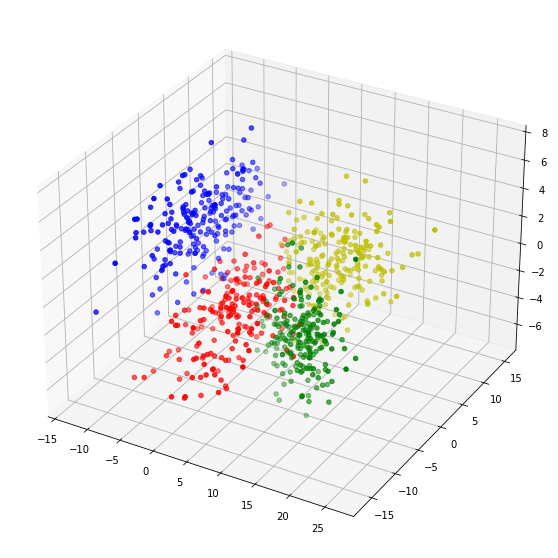

In [46]:
# Compelete GMM
def EM(X, K, iterations):
    # YOUR CODE HERE
    sigma, mu, pi=initialise_parameters(X,K)
    while iterations > 0:
        responsibilities = E_step(pi, mu, sigma, X)
        mu, sigma, pi = M_step(responsibilities, X)
        iterations -= 1
        
 
    return mu, sigma, pi


#Test code
iterations = 30
K = 4
mu_1, sigma_1, pi_1 = EM(X[:, :3], K, iterations)
print('\nSigma: \n', sigma_1)
print('\nMu: \n', mu_1)
print('\nPi: \n', pi_1)

def allocator(pi, mu, sigma, X, k):
    N = X.shape[0]
    cluster = []
    for ix in range(N):
        prospective_k = classify(pi, mu, sigma, X[ix, :])
        if prospective_k == k:
            cluster.append(X[ix, :])
    return np.asarray(cluster)

colours = ['r', 'g', 'b', 'y']
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
for k in range(K):
    cluster = allocator(pi_1, mu_1, sigma_1, X[:, :3], k)
    print(cluster.shape)
    ax.scatter(cluster[:,0], cluster[:,1], cluster[:, 2], c=colours[k])
plt.show()